In [1]:
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib qt

import numpy as np
from numpy import *
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy.optimize import curve_fit

import os
import scipy.io as sio

In [2]:
initial_folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9'

folders = os.listdir(initial_folder)
for i in range(len(folders)):
    if ".fig" in folders[i]: pass
    else: 
        print(r"[%d]" %(i), '----------->', folders[i])

[0] -----------> 1st_tone
[1] -----------> Alan_var
[2] -----------> Best_noise_power_sweep
[3] -----------> Best_noise_power_sweep_last_plot
[4] -----------> fast_saturation
[5] -----------> Gain_sweep_1000mK2025-07-17-22-37-20.mat
[6] -----------> Gain_sweep_10mK_power_freq2025-07-21-19-09-34.mat
[7] -----------> Gain_sweep_10mK_power_freq_1.382025-07-22-02-40-22.mat
[8] -----------> Gain_sweep_10mK_power_sweep_0.412025-07-22-12-30-24.mat
[9] -----------> Gain_sweep_10mK_power_sweep_0.412025-07-22-12-38-47.mat
[10] -----------> Gain_sweep_10mK_power_sweep_0.412025-07-22-12-40-36.mat
[11] -----------> Gain_sweep_12mK2025-05-29-12-17-35.mat
[12] -----------> Gain_sweep_12mK2025-05-29-13-27-37.mat
[13] -----------> Gain_sweep_12mK2025-06-03-10-58-46.mat
[14] -----------> Gain_sweep_12mK2025-06-03-18-18-22.mat
[15] -----------> Gain_sweep_12mK_test_save2025-06-05-17-57-06.mat
[16] -----------> Gain_sweep_500mK2025-07-08-15-36-23.mat
[17] -----------> Gain_sweep_700mK2025-07-12-17-11-02.m

In [10]:
file = folders[49]
mat = sio.loadmat(initial_folder+"\\"+file)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pump_powers', 'pump_freqs', 'volts', 'data_gain', 'data_mag', 'data_pha', 'fft_freq'])

In [11]:
BW = 10 
data_gain = mat['data_gain']
print(data_gain.shape)
volts = mat['volts'][0]
print(volts[4])
pump_freqs = mat['pump_freqs'][0]
print(pump_freqs[2])
pump_powers = mat['pump_powers'][0]
print(pump_powers[0])
data_mag = mat['data_mag']/ len(fft_freq) / BW * 2 # on/off
print(data_mag.shape)
data_pha = mat['data_pha']/ len(fft_freq) / BW * 2 # on/off
print(data_pha.shape)
fft_freq = mat['fft_freq'][0] # on/off
print(fft_freq.shape)

(101, 501, 1)
0.6
9018000000.0
7.0


NameError: name 'fft_freq' is not defined

In [ ]:
max_index = np.unravel_index(np.argmax(data_gain[4:,:,:]), data_gain[4:,:,:].shape)
best_gain_DC = max_index[0]
best_gain_pf = max_index[1]
best_gain_pp = max_index[2]
print(max_index)
data_gain[best_gain_DC+4, best_gain_pf, best_gain_pp]

In [ ]:
dc_idx = best_gain_DC+4
pp_idx = best_gain_pf
pf_idx = best_gain_pp

hz1_idx = 100

selected_gain_point = data_gain[dc_idx, pp_idx, pf_idx]
selected_pha_point = data_pha[dc_idx, pp_idx, pf_idx]
print(selected_gain_point)

font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize = (15, 7), sharex = True)
ax.grid()
ax.set_xlabel('freq')
ax.set_ylabel('Magnitude noise')


ax.loglog(fft_freq[51:], selected_pha_point[0,51:], '.-', label = 'ON')

# ax.plot(fft_freq[hz1_idx], selected_pha_point[0,hz1_idx], '.')

ax.loglog(fft_freq[51:], selected_pha_point[1,51:], '.-', label = 'OFF')

ax.legend()

In [ ]:
# critical point scearch

font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# fig1, ax1 = plt.subplots(1, 1, figsize = (15, 7), sharex = True)
# ax1.grid()
# ax1.set_xlabel('freq')
# ax1.set_ylabel('Phase noise')



def linear_func(x, a, b):
    return a * x + b

def linear_fit(x, y):
    popt, pcov = curve_fit(linear_func, x, y)
    a = popt[0]
    b = popt[1]
    return a, b


hz1_idx = 60

gain_arr = np.array([])
mag_1hz_arr = np.array([])
mag_1hz_arr_ref = np.array([])

pha_1hz_arr = np.array([])
pha_1hz_arr_ref = np.array([])

font = {'size'   : 20}
matplotlib.rc('font', **font)
fig2, ax2 = plt.subplots(1, 1, figsize=(15,7))
ax2.grid(True)
bin_edges = np.linspace(-5.7, -2, 20)

a=0
    
for dc_idx in range(len(volts)):
    pha_1hz_arr_DC = np.array([])
    for pp_idx in range(len(pump_powers)):
        for pf_idx in range(len(pump_freqs)):
        

            selected_gain_point = data_gain[dc_idx, pf_idx, pp_idx]
            selected_mag_point = data_mag[dc_idx,  pf_idx, pp_idx]
            selected_pha_point = data_pha[dc_idx, pf_idx, pp_idx]

            if selected_mag_point[0,hz1_idx] != 0: 
                a = a+1
                gain_arr = np.append(gain_arr, selected_gain_point)
                
                x = fft_freq[51:]
                y = selected_mag_point[0,51:]
                am, bm = linear_fit(np.log10(x[:-30]), np.log10(y[:-30]))
                
                y = selected_pha_point[0,51:]
                ap, bp = linear_fit(np.log10(x[:-30]), np.log10(y[:-30]))
                
                mag_1hz_arr = np.append(mag_1hz_arr, np.power(10, linear_func(np.log(1), am, bm)))
                mag_1hz_arr_ref = np.append(mag_1hz_arr_ref, selected_mag_point[1,hz1_idx])
                
                pha_1hz_arr = np.append(pha_1hz_arr, np.power(10, linear_func(np.log(1), ap, bp)))
                if linear_func(np.log(1), ap, bp)<-7.15:
                    print(selected_gain_point, volts[dc_idx], pump_freqs[pf_idx]/1e9, pump_powers[pp_idx], linear_func(np.log(1), ap, bp))
                
                pha_1hz_arr_DC = np.append(pha_1hz_arr_DC, np.power(10, linear_func(np.log(1), ap, bp)))

                    
                pha_1hz_arr_ref = np.append(pha_1hz_arr_ref, selected_pha_point[1,hz1_idx])
                
    
    if len(pha_1hz_arr_DC)>10:
        ax2.hist(np.log10(pha_1hz_arr_DC), bins=bin_edges, alpha=1, label=r'DC: {} V'.format(np.round(volts[dc_idx],2)))

                
#             if selected_gain_point>5 and selected_gain_point<5.15:
#                 x = fft_freq[51:]
#                 y = selected_pha_point[0,51:]
                
#                 a, b = linear_fit(np.log(x[:-30]), np.log(y[:-30]))
                
#                 ax1.loglog(x, y, '.-', label = r'G = {}, a = {}'.format(np.round(selected_gain_point,1), np.round(a,2)))
#                 ax1.loglog(x[:-30], np.exp(linear_func(np.log(x[:-30]), a, b)), color='black', alpha = 0.8, markersize=1, ls=":")
#                 ax1.legend()



ax[0].plot(gain_arr, np.log10(pha_1hz_arr), '.', label = 'All points')

ax[1].plot(gain_arr, np.log10(mag_1hz_arr/np.power(10, gain_arr / 10)), '.', label = 'All points')

ax[0].axhline(y=-5, color='r', linestyle='--', linewidth=1)
ax[1].axhline(y=-5.35, color='r', linestyle='--', linewidth=1)

ax[0].set_ylim(-6,-1.5)
ax[1].set_ylim(-6,-2)

ax[0].set_ylabel('Phase noise')

ax[1].set_xlabel('Gain')
ax[1].set_ylabel('Mag/gain noise')

ax[0].grid()
ax[1].grid()

# ax[0].legend(loc = 0)
ax2.legend()
# ax[1].legend(loc = 0)

In [ ]:
a*2.3/60*2

In [ ]:
# 180 fast sweep till mid

gain_arr_mid_180 = gain_arr
pha_1hz_arr_mid_180 = pha_1hz_arr
mag_1hz_arr_mid_180 = mag_1hz_arr

pha_1hz_arr_ref_mid_180 = pha_1hz_arr_ref
mag_1hz_arr_ref_mid_180 = mag_1hz_arr_ref



In [5]:
gain_arr_slow = gain_arr
pha_1hz_arr_slow = pha_1hz_arr
mag_1hz_arr_slow = mag_1hz_arr

pha_1hz_arr_ref_slow = pha_1hz_arr_ref
mag_1hz_arr_ref_slow = mag_1hz_arr_ref

NameError: name 'gain_arr' is not defined

In [6]:
gain_arr_break = gain_arr
pha_1hz_arr_break = pha_1hz_arr
mag_1hz_arr_break = mag_1hz_arr

pha_1hz_arr_ref_break = pha_1hz_arr_ref
mag_1hz_arr_ref_break = mag_1hz_arr_ref

NameError: name 'gain_arr' is not defined

NameError: name 'gain_arr_break' is not defined

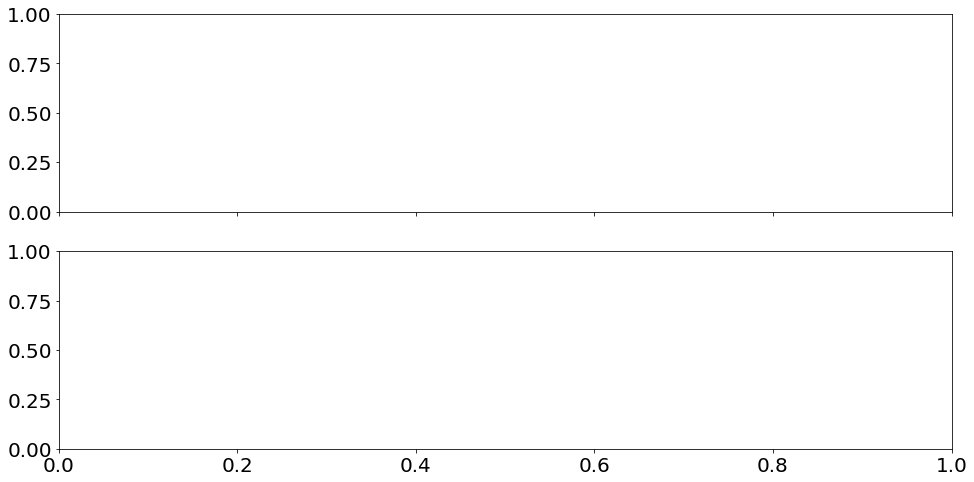

In [7]:
font = {'size'   :20}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(2, 1, figsize=(16,8), sharex=True)


# ax[1].plot(gain_arr_mid_180, np.log10(pha_1hz_arr_mid_180), '.')
# ax[0].plot(gain_arr_mid_180, np.log10(mag_1hz_arr_mid_180/np.power(10, gain_arr_mid_180 / 10)), '.')

# ax[1].plot(gain_arr_slow, np.log10(pha_1hz_arr_slow), '.')
# ax[0].plot(gain_arr_slow, np.log10(mag_1hz_arr_slow/np.power(10, gain_arr_slow / 10)), '.')

ax[1].plot(gain_arr_break, np.log10(pha_1hz_arr_break), '.')
ax[0].plot(gain_arr_break, np.log10(mag_1hz_arr_break/np.power(10, gain_arr_break / 10)), '.')

ax[1].axhline(y=-7.4, color='r', linestyle='--', linewidth=1, label = 'Min = -7.4')
ax[0].axhline(y=-8, color='r', linestyle='--', linewidth=1, label = 'Min = -8')
ax[1].set_ylim(-8,-3)
ax[0].set_ylim(-8.5,-4)
ax[1].set_ylabel('Phase noise')
ax[1].set_xlabel('Gain')
ax[0].set_ylabel('Mag/gain noise')
ax[1].grid()
ax[0].grid()
ax[0].legend()
ax[1].legend()
plt.savefig(r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\paper_plots\gain.png", dpi=300, bbox_inches='tight')


In [8]:
pha_1hz_arr_total = np.append(pha_1hz_arr_mid_180, pha_1hz_arr_slow)
pha_1hz_arr_total = np.append(pha_1hz_arr_total, pha_1hz_arr_break)

pha_1hz_arr_ref_total = np.append(pha_1hz_arr_ref_mid_180, pha_1hz_arr_ref_slow)
pha_1hz_arr_ref_total = np.append(pha_1hz_arr_ref_total, pha_1hz_arr_ref_break)

NameError: name 'pha_1hz_arr_mid_180' is not defined

NameError: name 'pha_1hz_arr_ref_total' is not defined

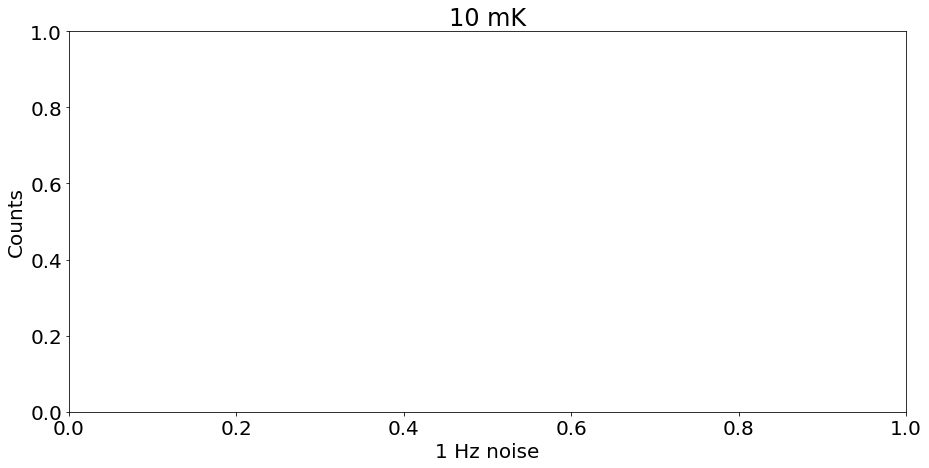

In [9]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.set_title("10 mK")
ax.set_ylabel("Counts")
ax.set_xlabel("1 Hz noise")


bin_edges = np.linspace(-7.8, -4, 150)

# ax.hist(np.log10(pha_1hz_arr)/np.log10(pha_1hz_arr_ref), bins=bin_edges, alpha=0.5, label='Phase noise/REF', color='blue')
ax.hist(np.log10(pha_1hz_arr_ref_total), bins=bin_edges, alpha=0.5, label='Phase noise - REF', color='red')
ax.hist(np.log10(pha_1hz_arr_total), bins=bin_edges, alpha=0.5, label='Phase noise', color='blue')


ax.legend()
ax.grid(True)
plt.savefig(r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\paper_plots\REf_TWPA.png", dpi=300, bbox_inches='tight')
plt.show()

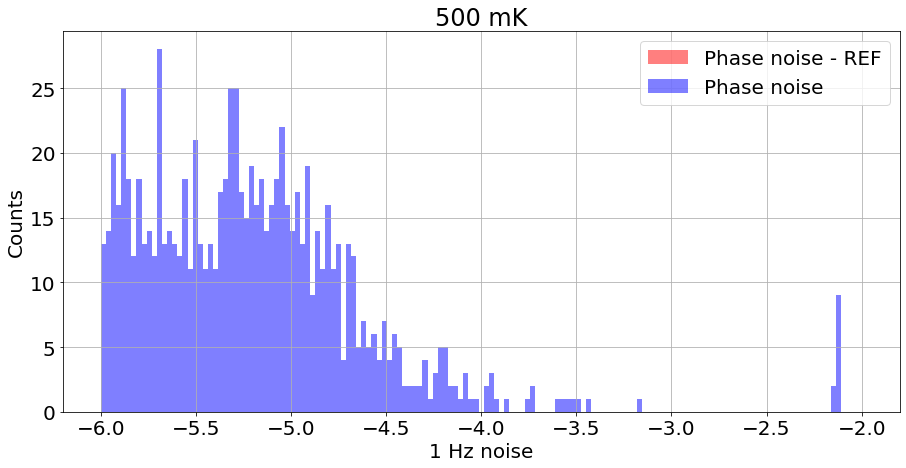

In [109]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.set_title("500 mK")
ax.set_ylabel("Counts")
ax.set_xlabel("1 Hz noise")


bin_edges = np.linspace(-6, -2, 150)

# ax.hist(np.log10(pha_1hz_arr)/np.log10(pha_1hz_arr_ref), bins=bin_edges, alpha=0.5, label='Phase noise/REF', color='blue')
ax.hist(np.log10(pha_1hz_arr_ref), bins=bin_edges, alpha=0.5, label='Phase noise - REF', color='red')
ax.hist(np.log10(pha_1hz_arr), bins=bin_edges, alpha=0.5, label='Phase noise', color='blue')


ax.legend()
ax.grid(True)

In [79]:
for i in range(10):

    print(f"{i}", end='\n' if i > 5 else '\r')

6
7
8
9


In [17]:
288-273

15